In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/stats207

/content/drive/.shortcut-targets-by-id/1BB-W8du-illju1EqYOHrL-R-3_okYgze/stats207


In [ ]:
import numpy as np 
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math

cites:
- 

# Data Pre-Processing

In [ ]:
# aqi_weekly = pd.read_csv('aqi_weekly_cleaned.csv')
# aqi_weekly.head()

aqi_daily = pd.read_csv("aqi_daily_cleaned.csv")
aqi_daily.head()

,Date,Overall.AQI.Value,Main.Pollutant,Site.Name..of.Overall.AQI.,CO,Ozone,PM25,NO2
0,2012-01-01,83,PM2.5,San Jose - Jackson,14,22,83,31
1,2012-01-02,75,PM2.5,San Jose - Jackson,16,19,75,35
2,2012-01-03,93,PM2.5,San Jose - Jackson,17,8,93,33
3,2012-01-04,97,PM2.5,San Jose - Jackson,20,19,97,42
4,2012-01-05,65,PM2.5,San Jose - Jackson,20,18,65,48


In [ ]:
aqi_daily = aqi_daily.drop(["Main.Pollutant", "Site.Name..of.Overall.AQI."], axis=1)
print(aqi_daily.shape)
aqi_daily.head()

(3653, 6)


,Date,Overall.AQI.Value,CO,Ozone,PM25,NO2
0,2012-01-01,83,14,22,83,31
1,2012-01-02,75,16,19,75,35
2,2012-01-03,93,17,8,93,33
3,2012-01-04,97,20,19,97,42
4,2012-01-05,65,20,18,65,48


In [ ]:
# Split Train and Test 
trainIDX = math.ceil(aqi_daily.shape[0] * 0.8)
# trainIDX = math.ceil(aqi_weekly.shape[0] * 0.8)

# train = aqi_weekly.iloc[0:trainIDX, 1:].values
# test = aqi_weekly.iloc[trainIDX:, 1:].values

train = aqi_daily.iloc[0:trainIDX, 1:].values
test = aqi_daily.iloc[trainIDX:, 1:].values

print(train.shape)
print(test.shape)

(2923, 5)
(730, 5)


In [ ]:
train[0]

array([83, 14, 22, 83, 31])

In [ ]:
# Normalize Input 
scaler = StandardScaler()  

train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

In [ ]:
train[0]

array([ 1.82759294,  1.46819611, -0.98070003,  2.10467178,  0.64936183])

# Dataset

In [ ]:
timesteps = 3
n_cols = 5

In [ ]:
def create_sequences(data, timesteps, n_cols):
  data_timesteps = np.array([[j for j in data[i:i+timesteps+1]] for i in range(0,len(data)-timesteps)])[:,:,]
  x, y = data_timesteps[:,:-1, :], data_timesteps[:,-1:, 0]

  return x, y 

In [ ]:
x_train, y_train = create_sequences(train, timesteps, n_cols)
print(x_train.shape, y_train.shape)

(415, 3, 5) (415, 1)


In [ ]:
print(x_train[0], y_train[0])

[[0.34860558 0.70422535 0.10734463 0.38649156 0.45783133]
 [0.39541833 0.76760563 0.12288136 0.43058161 0.59277108]
 [0.16533865 0.45774648 0.20480226 0.21013133 0.37831325]] [0.11055777]


In [ ]:
print(x_train[1], y_train[1])

[[0.39541833 0.76760563 0.12288136 0.43058161 0.59277108]
 [0.16533865 0.45774648 0.20480226 0.21013133 0.37831325]
 [0.11055777 0.27464789 0.15536723 0.15290807 0.28674699]] [0.21115538]


In [ ]:
torch.tensor(x_train).shape

torch.Size([415, 3, 5])

In [ ]:
class TimeSeries(Dataset):
    def __init__(self,data, timesteps, n_features):
        # create sequences of length timesteps, including n_features for each item in the sequence 
        data_timesteps = np.array([[j for j in data[i:i+timesteps+1]] for i in range(0,len(data)-timesteps)])[:,:,]
        x, y = data_timesteps[:,:-1, :], data_timesteps[:,-1:, 0]

        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = len(x)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

# LSTM 

In [ ]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,n_layers,dropout_prob):
        
        super(LSTM,self).__init__()

        #Hidden state: layers and dims (for use in forward)
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        #LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first = True, dropout = dropout_prob)

        #Final layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self,x):
        
        #Output
        out, (hn, cn) = self.lstm(x)
        #print(out.shape)
        out = self.fc(out[:,-1,:])
        #print(out.shape)
        #print(out)
        return out

# Train 

In [ ]:
N_FEATURES = train.shape[1]
INPUT_DIM = N_FEATURES
OUTPUT_DIM = 1

In [ ]:
# LSTM Hyperparameters
TIMESTEPS = 3
LEARNING_RATE = 0.001
N_EPOCHS = 10   # The number of times we loop over the whole dataset during training
BATCH_SIZE  = 32  # The size of input data took for one iteration of an epoch
DROPOUT = 0 
HIDDEN_DIM = 128
N_LAYERS = 3   # The number of layers in LSTM. 


In [ ]:
train_ts = TimeSeries(train, TIMESTEPS, N_FEATURES)
test_ts = TimeSeries(test, TIMESTEPS, N_FEATURES)

In [ ]:
train_loader = DataLoader(train_ts, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ts, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
model = LSTM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, 
          num_epochs=N_EPOCHS, learning_rate=LEARNING_RATE, verbose = True):

    for epoch in range(1, num_epochs + 1):
        batch_num = 1
        for inputs, targets in train_loader:  

            # If using GPU 
            if torch.cuda.is_available():
                model = model.cuda()
                inputs = inputs.cuda()
                targets = targets.cuda()

            optimizer.zero_grad() 
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step() 

            if verbose and batch_num % 5 == 0:  # Print every 5 batches                              
                print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_num}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
            
            batch_num += 1

In [ ]:
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=N_EPOCHS, learning_rate=LEARNING_RATE, verbose = False)

# Evaluation

In [ ]:
def evaluate(test_loader,batch_size, n_features):
  with torch.no_grad():
      predictions = []
      values = []

      for x_test, y_test in test_loader:
        batch_size = x_test.shape[0]
        x_test = x_test.view([batch_size, -1, n_features])
        y_preds = model(x_test)
        y_preds = [ j for i in y_preds.tolist() for j in i  ]
        y_test = [ j for i in y_test.tolist() for j in i  ]
        predictions.extend(y_preds)
        values.extend(y_test)

  return predictions, values

In [ ]:
y_test_preds, y_test = evaluate(test_loader, BATCH_SIZE, N_FEATURES)

In [ ]:
def inverse_transform(y, n_features):
  # Scaling back the predictions
  # some hacks to make inverse_transform work 
  # create empty table with n_cols fields
  data_like = np.zeros(shape=(len(y), n_features))
  # put the predicted values in the right field
  data_like[:, 0] = y # assuming aqi values are always in first column 
  # inverse transform and then select the right field
  return scaler.inverse_transform(data_like)[:,0]

In [ ]:
y_test_preds = inverse_transform(y_test_preds, N_FEATURES)
y_test = inverse_transform(y_test, N_FEATURES)

In [ ]:
def calculate_metrics(pred, actual, verbose = True):
    result_metrics = {'mae' : mean_absolute_error(pred, actual),
                      'mape' : mean_absolute_percentage_error(pred, actual),
                      'mse' : mean_squared_error(pred, actual), 
                      'rmse' : mean_squared_error(pred, actual) ** 0.5
                      }
    
    if verbose:
      print("Mean Absolute Error:       ", result_metrics["mae"])
      print("Mean Absolute Percentage Error:       ", result_metrics["mape"])
      print("Mean Squared Error:   ", result_metrics["mse"])
      print("Root Mean Squared Error:   ", result_metrics["rmse"])
      
    return result_metrics

In [ ]:
metrics = calculate_metrics(y_test_preds, y_test)

Mean Absolute Error:        9.589679563654938
Mean Absolute Percentage Error:        0.1865764650653077
Mean Squared Error:    223.4192660124424
Root Mean Squared Error:    14.94721599537661


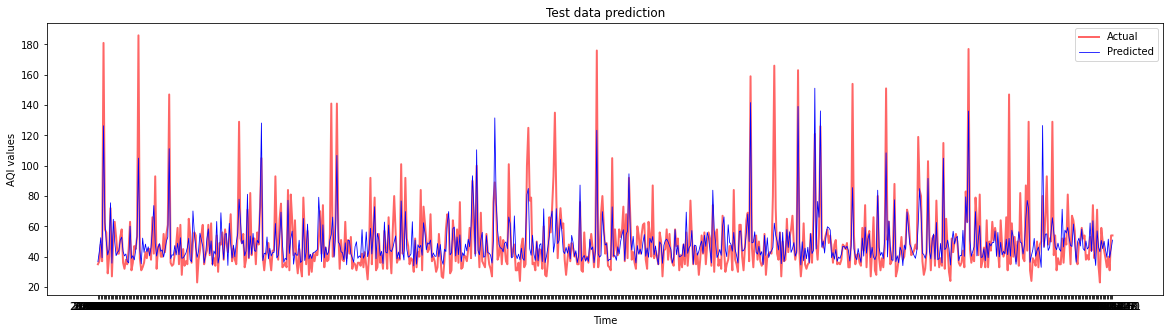

In [ ]:
#test_times = aqi_weekly.iloc[trainIDX+TIMESTEPS:,0]
test_times = aqi_daily.iloc[trainIDX+TIMESTEPS:,0]

plt.figure(figsize=(20,5))
plt.plot(test_times, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_times, y_test_preds, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Time')
plt.ylabel('AQI values')
plt.title('Test data prediction')
plt.show()

#Hyperparameter Tuning

In [ ]:
# LSTM Hyperparameters
TIMESTEPS = [1, 3, 5, 7]
LEARNING_RATE = [0.001]
N_EPOCHS = [10, 50, 100] 
BATCH_SIZE  = [32, 64, 128]  
DROPOUT = [0, 0.1, 0.5, 0.7] 
HIDDEN_DIM = [32, 128]
N_LAYERS = [2,3]

In [21]:
criterion = torch.nn.MSELoss()
errors_df = pd.DataFrame()

for t in TIMESTEPS:
  train_ts = TimeSeries(train, t, N_FEATURES)
  test_ts = TimeSeries(test, t, N_FEATURES) 

  for b in BATCH_SIZE:
    train_loader = DataLoader(train_ts, shuffle=True, batch_size=b)
    test_loader = DataLoader(test_ts, shuffle=True, batch_size=b)

    for l in LEARNING_RATE: 
      for e in N_EPOCHS:
        for d in DROPOUT:
          for h in HIDDEN_DIM:
            for n in N_LAYERS: 
                model = LSTM(INPUT_DIM, h, OUTPUT_DIM, n, d)
                optimizer = torch.optim.Adam(model.parameters(),lr=l)
                train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=e, learning_rate=l, verbose = False)

                y_test_preds, y_test = evaluate(test_loader, b, N_FEATURES)
                y_test_preds = inverse_transform(y_test_preds, N_FEATURES)
                y_test = inverse_transform(y_test, N_FEATURES)

                params = { 'timesteps': t, 'batch_size': b, 'learning_rate': l, 'epochs':e, 'dropout': d,
                          'hidden_dim': h, 'n_layers': n}
                metrics = calculate_metrics(y_test_preds, y_test, verbose = False)
                out_dict = {**params,  **metrics}

                errors_df = errors_df.append(out_dict, ignore_index=True)


errors_df = errors_df.sort_values(by="rmse")
errors_df.to_csv('LSTM_daily.csv')
errors_df.head(30)

,timesteps,batch_size,learning_rate,epochs,dropout,hidden_dim,n_layers,mae,mape,mse,rmse
280,3.0,128.0,0.001,100.0,0.5,32.0,2.0,9.303839,0.180352,207.217336,14.395046
256,3.0,128.0,0.001,50.0,0.0,32.0,2.0,9.144409,0.177367,209.268247,14.466107
405,5.0,128.0,0.001,50.0,0.1,32.0,3.0,9.285011,0.181464,209.782372,14.483866
530,7.0,128.0,0.001,10.0,0.0,128.0,2.0,9.209285,0.180370,209.902560,14.488014
435,7.0,32.0,0.001,10.0,0.0,128.0,3.0,9.099372,0.178501,210.107529,14.495086
531,7.0,128.0,0.001,10.0,0.0,128.0,3.0,9.450183,0.177782,210.254663,14.500161
544,7.0,128.0,0.001,50.0,0.0,32.0,2.0,9.336845,0.178150,210.500871,14.508648
432,7.0,32.0,0.001,10.0,0.0,32.0,2.0,9.458689,0.179964,211.190119,14.532382
433,7.0,32.0,0.001,10.0,0.0,32.0,3.0,9.666930,0.179789,211.194696,14.532539
545,7.0,128.0,0.001,50.0,0.0,32.0,3.0,9.355499,0.176466,212.130688,14.564707
